In [2]:
import torch
import torch.nn as nn
import diffusers
import matplotlib.pyplot as plt
import torchvision
from ema_pytorch import EMA
import tqdm.notebook as tqdm


In [3]:
dataset  = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


Files already downloaded and verified


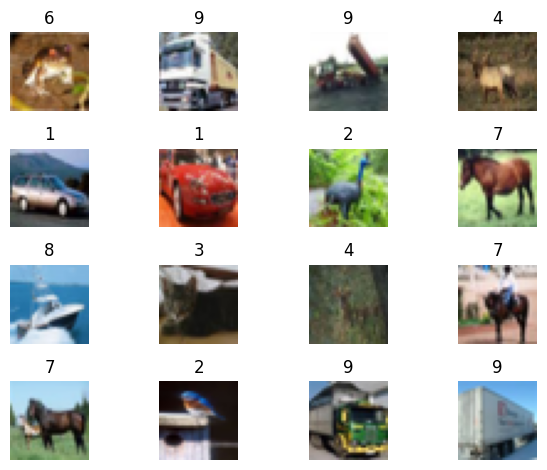

In [5]:
# Plot some images
fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(dataset[i*4+j][0].permute(1, 2, 0))
        axs[i, j].axis('off')
        axs[i, j].set_title(dataset[i*4+j][1])
        
plt.tight_layout()
plt.show()


In [6]:
scheduler = diffusers.DDIMScheduler(
    num_train_timesteps=4000,
    rescale_betas_zero_snr=True,
)


In [18]:
model = diffusers.UNet2DModel(
    sample_size=(32, 32),
    in_channels=3,
    out_channels=3,
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"), # "DownBlock2D", "AttnDownBlock2D", 
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D"), # "UpBlock2D", "AttnUpBlock2D",
    block_out_channels=(64, 128, 256),
    layers_per_block=4,
)


In [19]:
print(f"Model has {model.num_parameters():,} parameters.")


Model has 22,966,019 parameters.


In [20]:
device ="mps"


In [21]:
model = model.to(device)


In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5, weight_decay=1e-4)


In [23]:
ema = EMA(model, beta=0.9999, update_after_step=10, update_every=1)


In [24]:
# Train the model
with tqdm.tnrange(10) as epochs:
    for epoch in epochs:
        for i, (x, _) in enumerate(tqdm.tqdm(dataloader)):
            x = x.to(device)
            
            noise = torch.randn_like(x, device=device)
            timestep = torch.randint(0, 1000, (x.shape[0],), device=device).long()

            noisy_image = scheduler.add_noise(x, noise, timestep)

            model_output = model(noisy_image, timestep/1000).sample

            loss = torch.nn.functional.mse_loss(model_output, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # PSNR
            mse = loss
            psnr = -10 * torch.log10(mse)
            epochs.set_postfix(loss=loss.item(), psnr=psnr.item())
            ema.update()


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/50 [00:00<?, ?it/s]

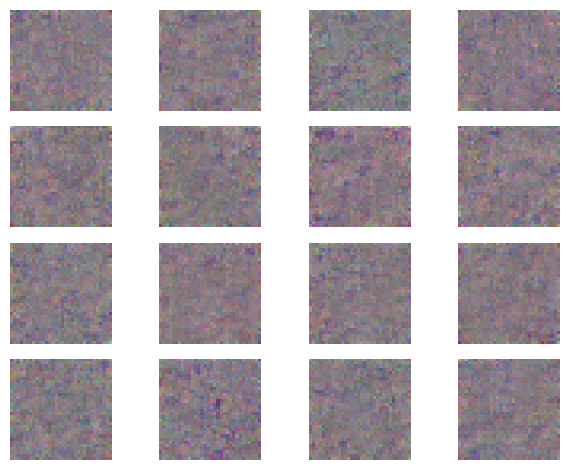

In [25]:
# Plot some images
pipeline = diffusers.DDIMPipeline(model, scheduler)

with torch.no_grad():
    imgs = pipeline(
        batch_size=16,
        num_inference_steps=50,
        output_type='np',
    ).images

fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(imgs[i*4+j].squeeze(), cmap='gray')
        axs[i, j].axis('off')
        
plt.tight_layout()
plt.show()
